# Unsupervised Anomaly Detection for Trail Cameras

Before running this notebook, prepare your data by running the `videos-to-frames.sh` script, e.g.
```sh
./videos-to-frames.sh /path/to/my/videos 10
```
This will extract frames at 10 FPS into subfolders named after each video.

## Imports

In [238]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage as ski
from PIL import Image
from imutils import paths
from skimage.transform import resize
from skimage.feature import hog
from sklearn.ensemble import IsolationForest
from tqdm.auto import tqdm

## Helper Functions

In [170]:
def norm_by_channel(x, min=0, max=255):
    """
    Normalizes each channel of x independently, meant for converting mag, angle from flow to HSV colorspace.
    If a batch dimension is included, x will be normalized using min & max from the whole batch.
    
    Inputs:
      x: ([B,] H, W, C) array of unnormalized data
      min: minimum of range to normalize data to
      max: maximum of range to normalize data to
    """
    chans = range(x.shape[-1])
    for ch in chans:
        spread = np.max(x[..., ch]) - np.min(x[..., ch])
        if spread == 0:
            x[..., ch] = max
            continue
        x[..., ch] = (x[..., ch] - np.min(x[..., ch]) + min) / spread * max
    return x



def find_data(data_dir):
    """
    Returns a dict of video subdirectories (key) with all images per directory (value).
    """
    image_files = {}
    image_dirs = list(filter(lambda x: os.path.isdir(os.path.join(data_dir, x)), os.listdir(data_dir)))
    for im_dir in image_dirs:
        image_files[im_dir] = sorted(list(paths.list_images(os.path.join(data_dir, im_dir))))
    return image_files


## Find data

In [165]:
data_dir = "/Users/jsanz/Downloads/100RECNX-critters/"

In [166]:
image_files = find_data(data_dir)
image_dirs = list(image_files.keys())

In [167]:
example_file = image_files[image_dirs[0]][0]
filename = os.path.basename(example_file)
fps = int(os.path.splitext(filename)[0].split('-')[1][3:])
print("FPS:", fps)

FPS: 10


## Load test video and demonstrate optical flow

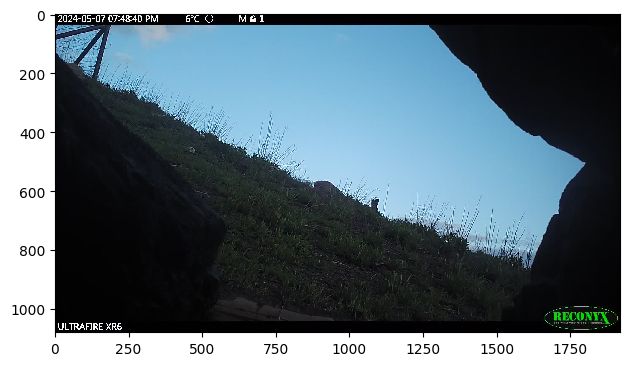

(1080, 1920, 3)


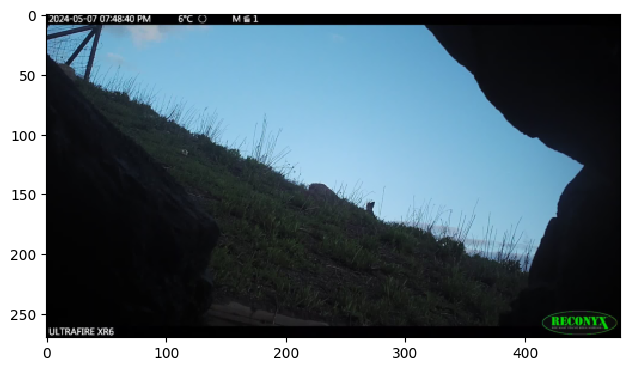

(270, 480, 3)


In [168]:
test_video = 'RCNX0073-Deer'
test_files = image_files[test_video]
test_images = [ski.io.imread(tf) for tf in test_files]
_ = ski.io.imshow(test_images[0])
plt.show()

im_size = test_images[0].shape
shrink_factor = 4
new_size = (im_size[0] / shrink_factor, im_size[1] / shrink_factor)
print(im_size)

test_images = [(resize(im, new_size) * 255).astype('uint8') for im in test_images]
im_size = test_images[0].shape
_ = ski.io.imshow(test_images[0])
plt.show()
print(im_size)

In [66]:
flows_hsv = [np.zeros_like(test_images[0]).astype('float32') for _ in range(len(test_images) - 1)]
# Flow images max saturation
for flow in flows_hsv:
    flow[..., 1] = 1

In [67]:
# See https://www.geeksforgeeks.org/opencv-the-gunnar-farneback-optical-flow/ for explanation
for idx in range(len(test_images) - 1):
    prv = cv2.cvtColor(test_images[idx], cv2.COLOR_BGR2GRAY)
    nxt = cv2.cvtColor(test_images[idx + 1], cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prv, nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    flows_hsv[idx][..., 0] = np.rad2deg(ang)
    flows_hsv[idx][..., 2] = mag
    # normed = norm_by_channel(flows_hsv[idx]).astype('uint8')
    # plt.hist(normed[..., 1].ravel())
    # plt.show()
    # normed = cv2.cvtColor(normed, cv2.COLOR_HSV2BGR)
    # ski.io.imshow(normed)
    # plt.show()
    # break


In [68]:
# Norm each channel across _all_ stills from video
flows_hsv = np.array(flows_hsv)
flows_hsv = norm_by_channel(flows_hsv)
flows_rgb = [cv2.cvtColor(fhsv.astype('uint8'), cv2.COLOR_HSV2RGB) for fhsv in flows_hsv]

In [69]:
len(test_images)

59

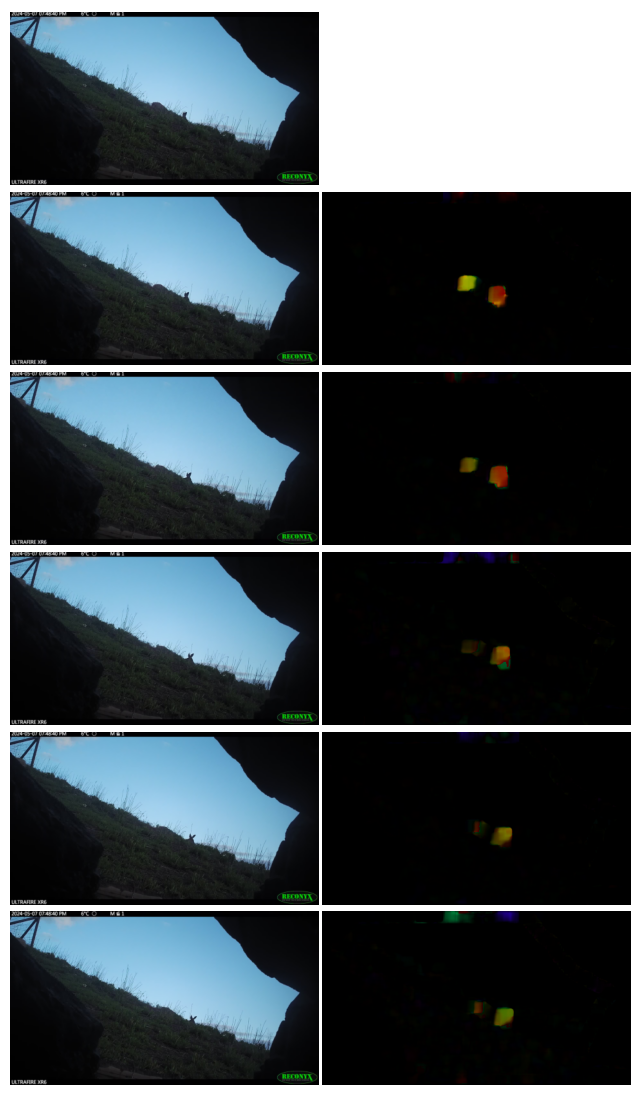

In [148]:
N = 6
fig, axs = plt.subplots(6, 2, figsize=(8,14))
for i in range(N):
    _ = axs[i, 0].imshow(test_images[i])
    axs[i, 0].set_axis_off()

for i in range(N - 1):
    _ = axs[i + 1, 1].imshow(flows_rgb[i])
    axs[i + 1, 1].set_axis_off()
axs[0, 1].set_axis_off()

plt.subplots_adjust(wspace=0.01, hspace=0.01)


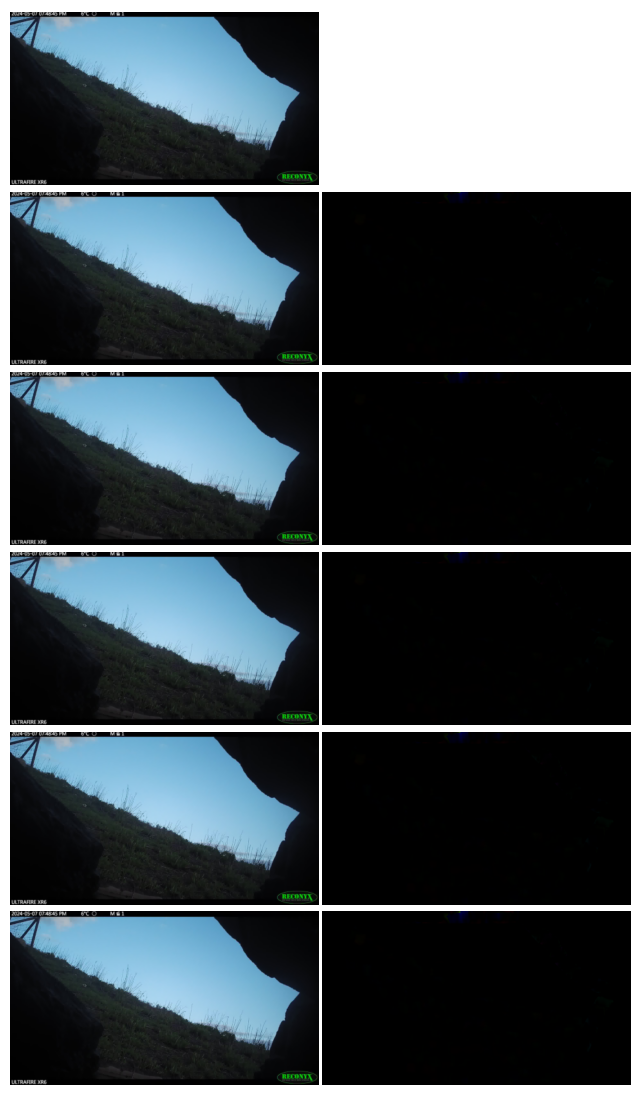

In [146]:
N = 6
fig, axs = plt.subplots(6, 2, figsize=(8,14))
for i in range(N):
    _ = axs[i, 0].imshow(test_images[-N + i])
    axs[i, 0].set_axis_off()
for i in range(N - 1):
    _ = axs[i + 1, 1].imshow(flows_bgr[-N + 1 + 1])
    axs[i + 1, 1].set_axis_off()
axs[0, 1].set_axis_off()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

## Train IsolationForest for anomaly detection

For now, use magnitude only of flow for detection. Also downscale flow images to reduce feature dimension.

In [94]:
# First, convert flow images to vectors and concatenate into training matrix for sklearn
X = flows_hsv[..., 2]
h, w = flows_hsv.shape[1:3]
X = np.array([resize(img, (h // 4, w // 4)) for img in X])
shape = X.shape
X = X.reshape(shape[0], -1)
X.shape

(58, 8040)

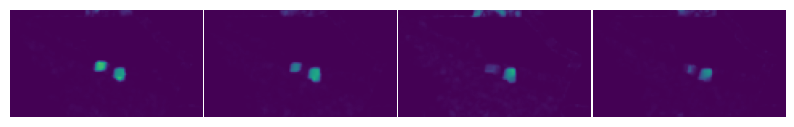

In [145]:
fig, axs = plt.subplots(1, 4, figsize=(10,4))
clim = np.min(X), np.max(X)
for i in range(4):
    _ = axs[i].imshow(X[i].reshape(h//4, w//4), clim=clim)
    axs[i].set_axis_off()
plt.subplots_adjust(wspace=0.01, hspace=0)


In [105]:
model = IsolationForest(n_estimators=256, contamination='auto', random_state=42)
model.fit(X)

IsolationForest(n_estimators=256, random_state=42)

In [106]:
preds = model.predict(X)
preds

array([ 1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1])

In [112]:
in_dist = np.where(preds > 0)[0]
outliers = np.where(preds < 0)[0]
outliers

array([ 1,  2,  4, 10])

Row 1: Outlier Image
Row 2: Outlier Optical Flow
Row 3: In-distribution Image
Row 4: In-distribution Optical Flow


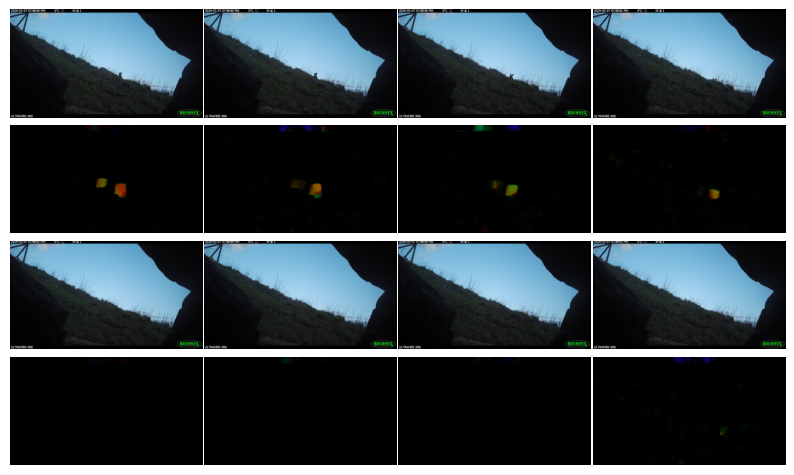

In [155]:
N = len(outliers)
fig, axs = plt.subplots(4, N, figsize=(2.5*N, 6))

for i, out in enumerate(outliers):
    _ = axs[0, i].imshow(test_images[out])
    _ = axs[1, i].imshow(flows_rgb[out])
    axs[0, i].set_axis_off()
    axs[1, i].set_axis_off()
    
for i, j in enumerate(np.random.choice(in_dist, N)):
    _ = axs[2, i].imshow(test_images[j])
    _ = axs[3, i].imshow(flows_rgb[j])
    axs[2, i].set_axis_off()
    axs[3, i].set_axis_off()

plt.subplots_adjust(wspace=0.01, hspace=0.01)
print("\n".join([
    "Row 1: Outlier Image",
    "Row 2: Outlier Optical Flow",
    "Row 3: In-distribution Image",
    "Row 4: In-distribution Optical Flow",
]))

## Putting it all together

In [237]:
def norm_by_channel(x, min=0, max=255):
    """
    Normalizes each channel of x independently, meant for converting mag, angle from flow to HSV colorspace.
    If a batch dimension is included, x will be normalized using min & max from the whole batch.
    
    Inputs:
      x: ([B,] H, W, C) array of unnormalized data
      min: minimum of range to normalize data to
      max: maximum of range to normalize data to
    """
    chans = range(x.shape[-1])
    for ch in chans:
        spread = np.max(x[..., ch]) - np.min(x[..., ch])
        if spread == 0:
            x[..., ch] = max
            continue
        x[..., ch] = (x[..., ch] - np.min(x[..., ch]) + min) / spread * max
    return x



def find_data(data_dir):
    """
    Returns a dict of video subdirectories (key) with all images per directory (value).
    """
    image_files = {}
    image_dirs = list(filter(lambda x: os.path.isdir(os.path.join(data_dir, x)), os.listdir(data_dir)))
    for im_dir in image_dirs:
        image_files[im_dir] = sorted(list(paths.list_images(os.path.join(data_dir, im_dir))))
    return image_files


def get_fps(image_files):
    """
    Expects `image_files` from `find_data()`, returns FPS of extracted frames.
    """
    example_file = image_files[list(image_files.keys())[0]][0]
    filename = os.path.basename(example_file)
    fps = int(os.path.splitext(filename)[0].split('-')[1][3:])
    return fps


def calculate_flows(files, downsample=4):
    """
    Load images from list `files`, downsample by `downsample`, and calculate optical flow.
    Returns 4D `np.array`s of size Nimages x H x W x C.
    """
    # Load and resize images
    images = [ski.io.imread(f) for f in files]
    new_size = (images[0].shape[0] // downsample, images[0].shape[1] // downsample)
    images = np.array([(resize(im, new_size) * 255).astype('uint8') for im in images])
    
    # Initialize flows
    dims = list(images.shape)
    dims[0] -= 1
    flows_hsv = np.zeros(dims, dtype=np.float32)
    flows_hsv[..., 1] = 1
    
    # Calculate flows
    for idx in range(len(images) - 1):
        prv = cv2.cvtColor(images[idx], cv2.COLOR_RGB2GRAY)
        nxt = cv2.cvtColor(images[idx + 1], cv2.COLOR_RGB2GRAY)
        # See https://www.geeksforgeeks.org/opencv-the-gunnar-farneback-optical-flow/ for param explanations
        flow = cv2.calcOpticalFlowFarneback(prv, nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        flows_hsv[idx][..., 0] = np.rad2deg(ang)
        flows_hsv[idx][..., 2] = mag
    flows_hsv = norm_by_channel(flows_hsv)

    return images, flows_hsv


def batch_hsv2rgb(hsv):
    """
    Converts a BxHxWx3 HSV image array to RGB
    """
    return np.array([cv2.cvtColor(ihsv.astype('uint8'), cv2.COLOR_HSV2RGB) for ihsv in hsv])


def detect_anomalies(flows, downsample=4, contamination='auto', random_state=42):
    """
    Train an IsolationForest on downsampled flows to detect anomalies.
    Returns `(outliers, in_dist)` tuple of vector of outlier indices and vector of 
    in-distribution indices.

    Inputs:
      `flows`: NxHxWx3 array of HSV flow images
      `downsample`: downsampling rate for final feature vector
      `contamination`: estimated proportion of outlier samples
      `random_state`: random seed
    """
    # First, convert flow images to vectors and concatenate into training matrix for sklearn
    X = flows[..., 2]  # Magnitude only for now
    h, w = flows.shape[1:3]
    X = np.array([resize(img, (h // downsample, w // downsample)) for img in X])
    X = X.reshape((X.shape[0], -1))
    # Train model
    model = IsolationForest(n_estimators=256, contamination=contamination, random_state=random_state)
    model.fit(X)
    # Predict outliers
    preds = model.predict(X)
    in_dist = np.where(preds > 0)[0]
    outliers = np.where(preds < 0)[0]
    return outliers, in_dist


def plot_anomalies(outliers, in_dist, images, flows_rgb, max_samples=4):
    """
    Plot a grid of anomaly images and flows, plus a sampling of in-distribution images. 
    Plot up to `max_samples` images at once.
    """
    fig, axs = plt.subplots(4, max_samples, figsize=(2.5*max_samples, 5.5))
    
    N = min(len(outliers), max_samples)
    for i, out in enumerate(np.random.choice(outliers, N, replace=False)):
        _ = axs[0, i].imshow(images[out])
        _ = axs[1, i].imshow(flows_rgb[out])
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    # Fill empty cells in grid
    for i in range(len(outliers), max_samples):
        _ = axs[0, i].imshow(np.zeros_like(images[0]))
        _ = axs[1, i].imshow(np.zeros_like(images[0]))
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()

    N = max_samples
    for i, j in enumerate(np.random.choice(in_dist, N, replace=False)):
        _ = axs[2, i].imshow(images[j])
        _ = axs[3, i].imshow(flows_rgb[j])
        axs[2, i].set_axis_off()
        axs[3, i].set_axis_off()
    
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.suptitle("\n".join([
        "Row 1 & 2: Outlier Image",
        "Row 3 & 4: In-distribution Image",
    ]))
    return fig


def process_videos(data_dir, contamination='auto', downsample=4):
    """
    Process a directory of videos looking for anomalies. 
    Inputs:
      `contamination`: estimate for proportion of outlier frames during training
      `downsample`: downsample rate from video resolution to stills for flow processing, 
                    and from flow resolution to final features for anomaly detection
    """
    image_files = find_data(data_dir)
    fps = get_fps(image_files)
    anomaly_counts = {}
    with tqdm(image_files.keys()) as prog:
        for video in prog:
            prog.set_postfix({"Video": video, "Stage": "flows"}, refresh=True)
            files = image_files[video]
            images, flows = calculate_flows(files, downsample=downsample)
            flows_rgb = batch_hsv2rgb(flows)
            prog.set_postfix({"Video": video, "Stage": "anomalies"}, refresh=True)
            outliers, in_dist = detect_anomalies(flows, downsample=downsample, contamination=contamination)
            Nout = len(outliers)
            prog.set_postfix({"Video": video, "Stage": "saving results"}, refresh=True)
            fig = plot_anomalies(outliers, in_dist, images, flows_rgb, max_samples=6)
            fig.savefig(os.path.join(data_dir, f"{video}_anomaly_samples.jpg"), bbox_inches='tight')
            plt.close(fig)
            with open(os.path.join(data_dir, f"{video}_summary.txt"), "w") as f:
                f.writelines([
                    f"{Nout} anomalies predicted.\n\n",
                    f"Index, Frame, Timestamp\n",
                ])
                f.writelines(
                    [f"{i}, {outliers[i]}, {outliers[i] / fps}\n" for i in range(Nout)]
                )
            anomaly_counts[video] = Nout
            
    return anomaly_counts

In [228]:
# data_dir = "/Users/jsanz/Downloads/100RECNX-critters/"
data_dir = "/Users/jsanz/Downloads/100MEDIA-no-critters/"

image_files = find_data(data_dir)
video = "DSCF0065"  # np.random.choice(list(image_files.keys()))
print("Using video", video)
files = image_files[video]

images, flows = calculate_flows(files, downsample=4)
flows_rgb = batch_hsv2rgb(flows)

outliers, in_dist = detect_anomalies(flows, downsample=4, contamination='auto')


Using video DSCF0065


1


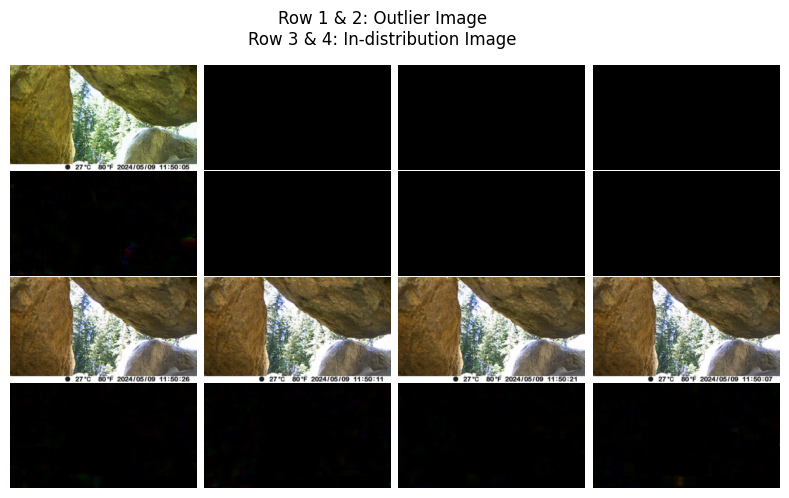

In [229]:
fig = plot_anomalies(outliers, in_dist, images, flows_rgb, max_samples=4)

In [235]:
# data_dir = "/Users/jsanz/Downloads/100RECNX-critters/"
data_dir = "/Users/jsanz/Downloads/100MEDIA-no-critters/"
counts = process_videos(data_dir, downsample=6)
print(counts)

  0%|          | 0/27 [00:00<?, ?it/s]

In [251]:
data_dir = "/Users/jsanz/Downloads/100RECNX-critters/"
# data_dir = "/Users/jsanz/Downloads/100MEDIA-no-critters/"
summaries = glob.glob(os.path.join(data_dir, "*.txt"))
videos = [os.path.splitext(os.path.basename(s))[0].split("_")[0] for s in summaries]
counts = []
for s in summaries:
    with open(s, "r") as f:
        text = f.readline()
    count = int(text.strip().split(" ")[0])
    counts.append(count)
counts = np.array(counts)
idxs = np.argsort(counts)[::-1]
counts = counts[idxs]
videos = np.array(videos)[idxs]
print("Video: detections")
for v, c in zip(videos, counts):
    print(f"{v}: {c}")

Video: detections
RCNX0025-Bird: 14
RCNX0067: 10
RCNX0057: 8
RCNX0078: 7
RCNX0035: 7
RCNX0065-Bird: 6
RCNX0030: 5
RCNX0068: 4
RCNX0073-Deer: 3
RCNX0066-Bird: 3
RCNX0060-Deer: 2
